# Chapter 7 - Notes

## Set Up

### Packages

In [156]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit, logsumexp, softmax
from sklearn.preprocessing import StandardScaler

### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

Set seed

In [5]:
rng = np.random.default_rng(RANDOM_SEED)

## 7.1 The problem with parameters

In [6]:
# generate the data
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

Define a polynomial model (we can just use a log-normal prior on $\sigma$ rather than a normal prior for the log).

In [7]:
def sample_polynomial_model(brains, poly_deg, sigma_val=None):
    mass_mean = brains.mass.mean()
    mass_std = brains.mass.std()

    brain_max = brains.brain.max()

    degrees = range(1, poly_deg + 1)
    coords = {
        "species": brains.species.values,
        "degree": degrees,
    }
    with pm.Model(coords_mutable=coords) as model:
        # data
        mass = pm.MutableData("mass", brains.mass, dims="species")
        mass_std = pm.Deterministic(
            "mass_std", (mass - mass_mean) / mass_std, dims="species"
        )
        mass_std_poly = pm.Deterministic(
            "mass_std_poly",
            pm.math.stack([mass_std**deg for deg in degrees]),
            dims=("degree", "species"),
        )

        # priors
        alpha = pm.Normal("alpha", mu=0.5, sigma=1)
        beta = pm.Normal("beta", mu=0, sigma=10, dims="degree")
        if not sigma_val:
            sigma = pm.LogNormal("sigma", mu=0, sigma=1)

        # linear model
        mu = pm.Deterministic("mu", alpha + beta @ mass_std_poly, dims="species")
        mu_unstd = pm.Deterministic("mu_unstd", mu * brain_max, dims="species")

        # likelihood
        if sigma_val:
            brain_std = pm.Normal(
                "brain_std",
                mu=mu,
                sigma=sigma_val,
                observed=brains.brain / brain_max,
                dims="species",
            )
        else:
            brain_std = pm.Normal(
                "brain_std",
                mu=mu,
                sigma=sigma,
                observed=brains.brain / brain_max,
                dims="species",
            )

        # inference button
        trace = pm.sample(random_seed=RANDOM_SEED)

    return model, trace

In [160]:
def r2_score(model, trace):
    with model:
        post_trace = pm.sample_posterior_predictive(
            trace,
            var_names=["brain_std"],
            random_seed=RANDOM_SEED,
        )
    
    resid = post_trace.posterior_predictive.brain_std.mean(dim=["chain", "draw"]) - trace.observed_data.brain_std
    resid_var = resid.var()
    
    obs_var = trace.observed_data.brain_std.var()
    
    return (1 - resid_var / obs_var).item()

In [161]:
def predict_brains_polynomial_counterfactuals(model, trace, mass_pred):
    with model:
        pm.set_data(
            {
                "mass": mass_pred,
            },
            coords={
                "species": range(len(mass_pred)),
            },
        )
        trace = pm.sample_posterior_predictive(
            trace,
            var_names=["mu", "mu_unstd"],
            extend_inferencedata=True,
            predictions=True,
            random_seed=RANDOM_SEED,
        )

    return trace

In [162]:
def plot_brains_polynomial_posterior(brains, trace, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    sns.scatterplot(brains, x="mass", y="brain", ax=ax)

    mean = trace.predictions.mu_unstd.mean(dim=["chain", "draw"])
    ax.plot(
        trace.predictions_constant_data.mass,
        mean,
        color="k",
    )

    hdi = az.hdi(trace.predictions.mu_unstd, hdi_prob=0.89).mu_unstd
    ax.fill_between(
        trace.predictions_constant_data.mass,
        hdi.sel(hdi="lower"),
        hdi.sel(hdi="higher"),
        color="k",
        alpha=0.3,
    )

    return ax

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [brain_std]


Sampling: []


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [brain_std]


Sampling: []


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [brain_std]


Sampling: []


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 481 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [brain_std]


Sampling: []


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 704 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [brain_std]


Sampling: []


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [brain_std]


Sampling: []


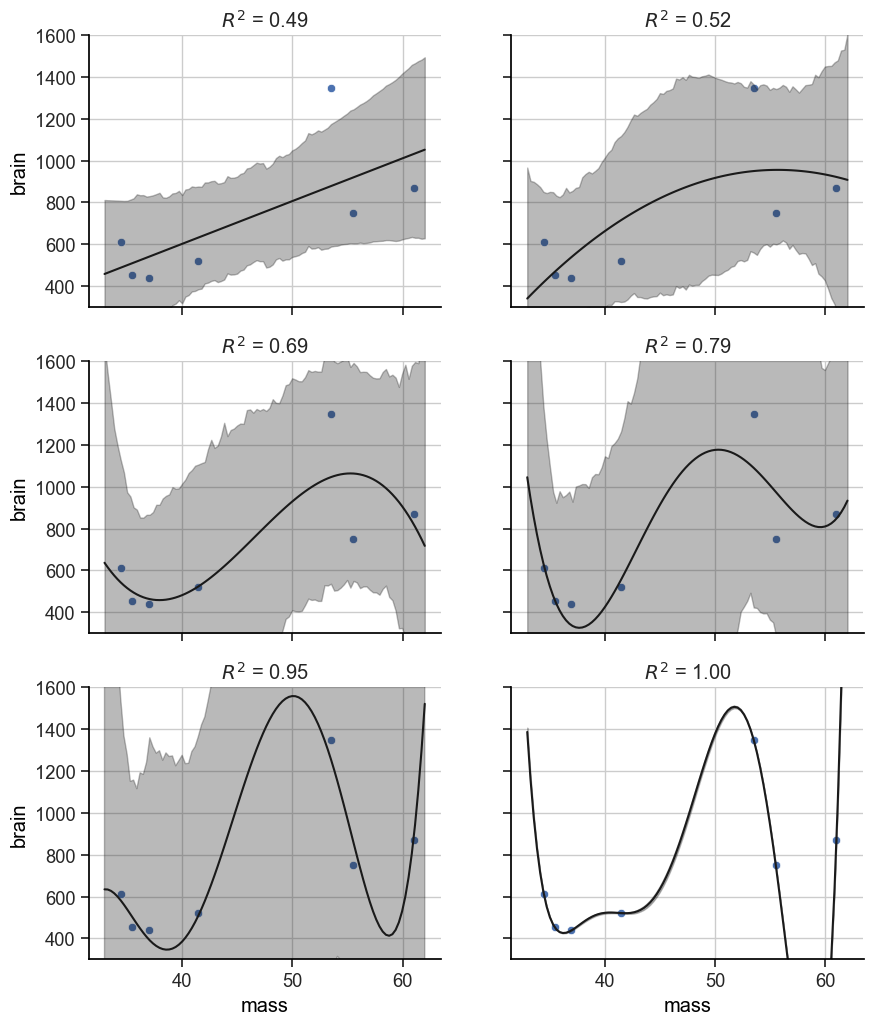

In [163]:
poly_degs = range(1, 7)
sigma_vals = 5 * [None] + [0.001]
mass_pred = np.linspace(33, 62, 100)

fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(10, 12))

models = dict.fromkeys(poly_degs)
traces = dict.fromkeys(poly_degs)

for poly_deg, sigma_val, ax in zip(poly_degs, sigma_vals, axs.ravel()):
    model, trace = sample_polynomial_model(brains, poly_deg, sigma_val)
    r2 = r2_score(model, trace)
    trace = predict_brains_polynomial_counterfactuals(model, trace, mass_pred)
    plot_brains_polynomial_posterior(brains, trace, ax=ax)

    ax.set(
        ylim=[300, 1600],
        title=f"$R^2$ = {r2:.2f}",
    )

    models[poly_deg] = model
    traces[poly_deg] = trace

I don't understand why I'm getting divergences here but when I look up other solutions online they use other methods rather than PyMC sampling.
I assume that there's some underlying problem and that's also the reason my HDIs are so wide.

## 7.2 Entropy and accuracy

### 7.2.4 Estimating divergence

Calculate the LPPD of the linear model.

In [165]:
m7_1, trace_7_1 = sample_polynomial_model(brains, poly_deg=1, sigma_val=None)

with m7_1:
    pm.compute_log_likelihood(trace_7_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [169]:
def log_pointwise_predictive_density(log_likelihood):
    draw_idx = log_likelihood.dims.index("draw")
    n_draws = log_likelihood.shape[draw_idx]
    return np.sum(
        logsumexp(log_likelihood, axis=draw_idx, b=1./n_draws),
        axis=draw_idx,
    )

In [170]:
log_pointwise_predictive_density(trace_7_1.log_likelihood.brain_std)

array([1.34221854, 1.3492704 , 1.45060201, 1.32004688])

For some reason my values are off from the values in the book by a factor of about 1.7 (this is consistently true for each sample).

Now we can get the same for each model.

In [171]:
lppds = dict.fromkeys(poly_degs)
for poly_deg in poly_degs:
    model = models[poly_deg]
    trace = traces[poly_deg]
    with model:
        # reset coords
        pm.set_data(
            {
                "mass": brains.mass,
            },
            coords={
                "species": brains.species.values,
            },
        )
        
        # add log likelihoods to trace
        pm.compute_log_likelihood(trace)
    
    lppds[poly_deg] = log_pointwise_predictive_density(
        trace.log_likelihood.brain_std
    )

In [172]:
{poly_deg: np.mean(lppd).round(2) for poly_deg, lppd in lppds.items()}

{1: 1.37, 2: 0.8, 3: 0.48, 4: -0.3, 5: -1.35, 6: 39.54}

These seem wildly wrong (they certainly shouldn't be decreasing), but I guess this is a reflection of the problem with the models.